In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

### Set up paths

In [2]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [3]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
path = Path('/root/.fastai/data/severstal')

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/severstal-steel-defect-detection.zip'),
 PosixPath('/root/.fastai/data/severstal/test_images'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/submission.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip')]

In [6]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/18ba753ff.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/0519989b3.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/7933cbe21.jpg')]

### Check maximum size of images

In [7]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

In [8]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [9]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [10]:
grouped_categories_mask = group_by(train_images, train_pd)

### Create mask files and save these to kaggle/mask/

In [11]:
image_height = 256
image_width = 1600
for image_name, cat_list in grouped_categories_mask.items():
    masked = np.zeros([image_height, image_width])
    for cat_mask in cat_list:
        encoded_pixels = cat_mask[1]
        if pd.notna(cat_mask[1]):
            masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
    if np.amax(masked) > 4:
        print(f'Check {image_name} for max category {np.amax(masked)}')
    save_to_image(masked, image_name)

### Prepare data bunch

In [12]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])
valid_pct = 0.10

In [13]:
codes = array(['0', '1', '2', '3', '4'])

In [14]:
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))

In [15]:
bs = 4
size = src_size//2

In [16]:
data = (src.transform(get_transforms(flip_vert = True), size=size, tfm_y=True)
        .add_test(ImageList.from_folder(path/'test_images'), tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total[b] = 1
        else:
            mask = target[b] != void_code
            comparison = argmax[b][mask]==target[b][mask]
            total[b] = torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total.mean()


def calc_dice_coefficients(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0)
        return (torch.sum((seg[gt == cat] / cat).float()) * 2.0) / (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats)])
    for i, c in enumerate(cats):
        total_avg[i] = calc_dice_coefficient(argmax, target, c)
    return total_avg.mean()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients(argmax[b], target[b], cats)
    return total.mean()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [18]:
metrics=accuracy_simple,acc_camvid_with_zero_check,dice_coefficient
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.5, .5, .5, .5, .5]).cuda())
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [20]:
learn.model_dir = Path('/kaggle/model')

In [21]:
learn = to_fp16(learn, loss_scale=3.0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


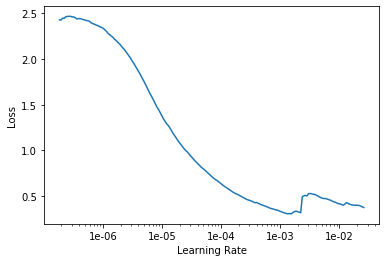

In [22]:
lr_find(learn, num_it=300)
learn.recorder.plot()

In [23]:
lr=1e-04

In [24]:
from fastai import callbacks

learn.fit_one_cycle(12, slice(lr), pct_start=0.8, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4),
                              callbacks.ReduceLROnPlateauCallback(learn=learn, monitor='dice_coefficient', patience=3),
                              callbacks.TerminateOnNaNCallback()])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.194080,0.096570,0.969928,0.099570,0.644226,07:20
1,0.060216,0.046682,0.970668,0.210739,0.721941,07:23
2,0.043005,0.039661,0.973054,0.410329,0.838326,07:21
3,0.049489,0.035495,0.975365,0.530133,0.874695,07:22
4,0.040942,0.035548,0.975051,0.519070,0.872515,07:23
5,0.047167,0.034815,0.972264,0.487369,0.865718,07:22
6,0.053906,0.035770,0.975494,0.537284,0.874514,07:23
7,0.037810,0.045047,0.975306,0.557063,0.883907,07:23
8,0.039166,0.030071,0.975996,0.555325,0.884768,07:22
9,0.045633,0.030814,0.977721,0.569000,0.876044,07:23


Better model found at epoch 0 with dice_coefficient value: 0.6442261338233948.
Better model found at epoch 1 with dice_coefficient value: 0.7219405174255371.
Better model found at epoch 2 with dice_coefficient value: 0.8383257389068604.
Better model found at epoch 3 with dice_coefficient value: 0.8746954202651978.
Better model found at epoch 7 with dice_coefficient value: 0.8839072585105896.
Better model found at epoch 8 with dice_coefficient value: 0.8847676515579224.
Better model found at epoch 11 with dice_coefficient value: 0.8954336643218994.


In [25]:
learn.save('stage-1')

In [26]:
# learn.load('bestmodel');

In [27]:
learn.export(file='/kaggle/model/export-1.pkl')

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/100,lr)

In [30]:
learn.fit_one_cycle(10, lrs, pct_start=0.8, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-unfrozen-1-mini'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4),
                              callbacks.ReduceLROnPlateauCallback(learn=learn, monitor='dice_coefficient', patience=3),
                              callbacks.TerminateOnNaNCallback()])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.028513,0.027139,0.978967,0.620448,0.896909,08:02
1,0.035460,0.027651,0.980332,0.631790,0.895134,08:02
2,0.045054,0.027779,0.980399,0.616895,0.896971,08:02
3,0.030985,0.027285,0.977822,0.596305,0.893357,08:03
4,0.033357,0.030469,0.977618,0.606445,0.898264,08:03
5,0.032896,0.034315,0.978115,0.626100,0.901457,08:03
6,0.033545,0.033436,0.976040,0.581886,0.889349,08:04
7,0.037120,0.029933,0.979331,0.630560,0.904794,08:04


Better model found at epoch 0 with dice_coefficient value: 0.8969089984893799.
Better model found at epoch 2 with dice_coefficient value: 0.8969712257385254.
Better model found at epoch 4 with dice_coefficient value: 0.8982641100883484.
Better model found at epoch 5 with dice_coefficient value: 0.9014570116996765.
Better model found at epoch 7 with dice_coefficient value: 0.9047939777374268.
Epoch/Batch (8/293): Invalid loss, terminating training.


In [59]:
learn.save('stage-2');

In [ ]:
learn.load('bestmodel-unfrozen-diceloss-mini');

In [60]:
learn.export(file='/kaggle/model/export-2.pkl')

### Go Large

In [ ]:
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=valid_pct)
       .label_from_func(get_y_fn, classes=codes))

In [65]:
data = (src.transform(get_transforms(flip_vert = True), size=src_size, tfm_y=True)
        .add_test(ImageList.from_folder(path/'test_images'), tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [68]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.model_dir = Path('/kaggle/model')
learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.5, .5, .5, .5, .5]).cuda())
learn = to_fp16(learn, loss_scale=2.0)
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


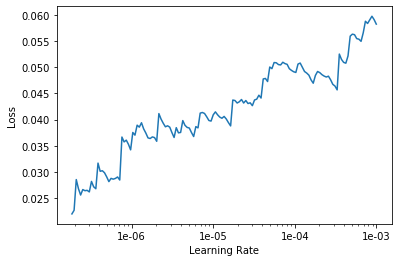

In [69]:
lr_find(learn, num_it=300)
learn.recorder.plot()

In [70]:
lr=1e-07

In [71]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.3, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-3'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4),
                              callbacks.TerminateOnNaNCallback()])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.039190,0.029456,0.977469,0.445558,0.833907,21:23
1,0.039215,0.029241,0.977825,0.464921,0.843692,21:24
2,0.043979,0.029234,0.977706,0.455207,0.843109,21:25
3,0.042141,0.028613,0.978034,0.483397,0.854906,21:24
4,0.043168,0.029469,0.977947,0.469638,0.847649,21:25
5,0.049357,0.028553,0.978377,0.494755,0.856987,21:24
6,0.051687,0.029159,0.978150,0.489901,0.859099,21:25
7,0.037286,0.029181,0.978349,0.485891,0.853854,21:25
8,0.045945,0.029493,0.977969,0.495052,0.856391,21:25
9,0.032826,0.028999,0.978360,0.496785,0.856144,21:25


Better model found at epoch 0 with dice_coefficient value: 0.8339073061943054.
Better model found at epoch 1 with dice_coefficient value: 0.8436923623085022.
Better model found at epoch 3 with dice_coefficient value: 0.8549055457115173.
Better model found at epoch 5 with dice_coefficient value: 0.8569872379302979.
Better model found at epoch 6 with dice_coefficient value: 0.8590989112854004.


In [72]:
learn.save('stage-3');

In [73]:
learn.export(file='/kaggle/model/export-3.pkl')

In [51]:
learn.load('bestmodel-3');

In [74]:
learn.load('stage-3');

In [75]:
learn.unfreeze()

In [76]:
lrs = slice(lr/1000,lr/10)

In [77]:
learn.fit_one_cycle(2, lrs, pct_start=0.8,
                   callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-4'),
                             callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4),
                             callbacks.TerminateOnNaNCallback()])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.046769,0.028504,0.978292,0.495423,0.859987,22:34
1,0.042712,0.028724,0.978317,0.487007,0.854116,22:34


Better model found at epoch 0 with dice_coefficient value: 0.8599867820739746.


In [78]:
learn.save('stage-4');

In [ ]:
learn.load('stage-4');

In [79]:
learn.export(file='/kaggle/model/export-4.pkl')

In [80]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export-4.pkl')

/opt/fastai/fastai-exercises/nbs_gil


/opt/fastai/fastai-exercises/nbs_gil/export-4.pkl

### Inference

In [69]:
learn=None
gc.collect()

231

In [71]:
test_images = (path/'test_images').ls()

In [73]:
!mv /kaggle/model/export-4.pkl /kaggle/model/export.pkl 

In [74]:
inference_learn = load_learner('/kaggle/model/')

In [76]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

/root/.fastai/data/severstal/train_images/f21b0be46.jpg
/root/.fastai/data/severstal/train_images/f21b0be46.jpg


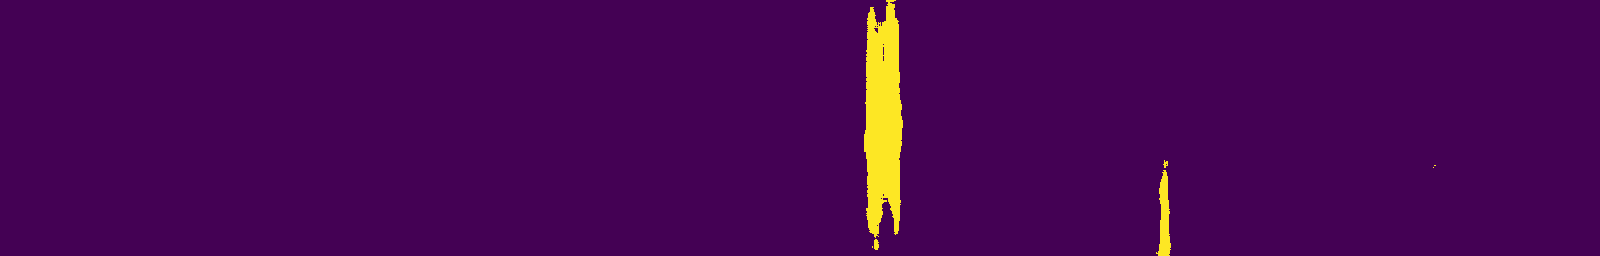

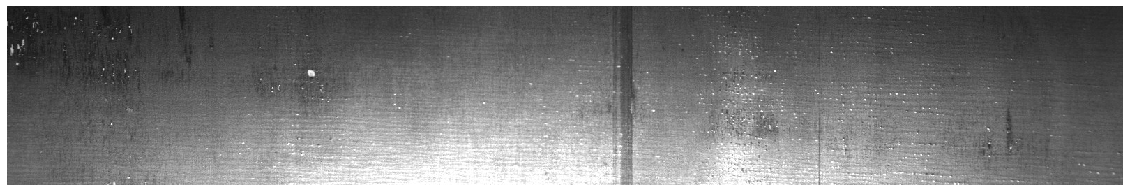

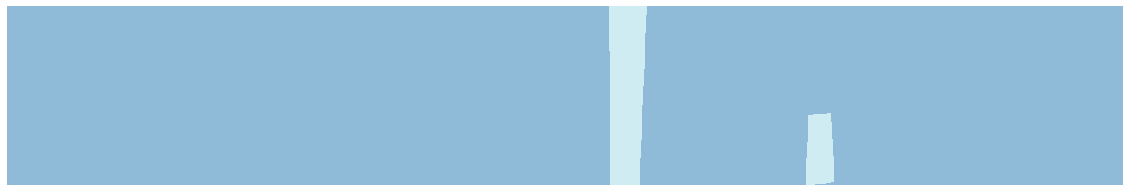

In [77]:
image_to_predict = train_images[16].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

In [80]:
torch.transpose(pred_class.data.squeeze(), 0, 1).shape

torch.Size([1600, 256])

#### Checking encoding methods

In [78]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

221319 18 221543 2 221571 22 221747 2 221751 2 221754 4 221759 15 221775 3 221779 7 221787 69 221905 3 221910 1 221912 1 221971 2 221974 4 221979 1 221981 1 221983 1 221985 7 221993 132 222129 9 222139 2 222143 3 222147 3 222161 12 222222 215 222477 218 222696 1 222728 226 222984 226 223240 227 223479 2 223496 1 223498 225 223757 16 223774 208 223985 9 224016 1 224020 7 224028 1 224032 207 224240 11 224279 6 224289 204 224496 11 224538 1 224540 1 224546 192 224739 8 224748 1 224753 10 224791 212 225005 1 225011 1 225013 4 225048 1 225051 197 225303 200 225563 172 225736 19 225815 182 226001 1 226004 4 226071 22 226094 2 226104 1 226110 133 226245 2 226249 3 226326 177 226505 2 226582 177 226761 2 226817 2 226823 192 227017 2 227073 2 227077 1 227079 192 227329 202 227585 204 227841 2 227844 203 228049 2 228097 2 228100 208 228353 2 228357 210 228569 1 228609 2 228613 214 228865 1 228869 4 228875 222 229098 1 229121 1 229139 217 229395 216 229653 214 229910 1 229913 207 230217 11 230233

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")

### Alternative prediction methods

In [57]:
preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)

In [58]:
preds.shape

torch.Size([1801, 5, 128, 800])

In [82]:
pred_class_data = preds.argmax(dim=1)

torch.Size([1801, 5, 128, 800])

In [67]:
len((path/'test_images').ls())

1801

In [68]:
data.test_ds.x

SegmentationItemList (1801 items)
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
Path: /root/.fastai/data/severstal/train_images